<a href="https://colab.research.google.com/github/mahesh-keswani/pytorch-example-notebook/blob/main/8_PytorchWithRGBImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def getData(train = False):
    dataset = torchvision.datasets.CIFAR10(
        root = ".",
        train = train,
        download = True,
        transform = transforms.ToTensor()
    )
    return dataset

In [3]:
trainDataset = getData(train = True)
testDataset = getData(train = False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainDataset.data.shape

(50000, 32, 32, 3)

In [5]:
batchSize = 128
trainLoader = torch.utils.data.DataLoader(
    trainDataset,
    batch_size = batchSize,
    shuffle = True
)

testLoader = torch.utils.data.DataLoader(
    testDataset,
    batch_size = batchSize,
    shuffle = False
)

In [6]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, stride = 2, kernel_size = 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, stride = 2, kernel_size = 3),
            nn.ReLU(),
            nn.Conv2d(64, 128, stride = 2, kernel_size = 3),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1152, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 10)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.dense_layers(x)
        return x


In [7]:
criterion = nn.CrossEntropyLoss()
model = MyCNN()
optimizer = torch.optim.Adam( model.parameters())

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


MyCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1152, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [9]:
EPOCHS = 15
trainLosses = np.zeros(EPOCHS)
testLosses = np.zeros(EPOCHS)

for epoch in range(EPOCHS):
    start = time.time()

    trainLoss = []
    for inputs, targets in trainLoader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        trainLoss.append( loss.item() )
    
    trainLosses[epoch] = np.mean(trainLoss)

    testLoss = []
    for inputs, targets in testLoader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        testLoss.append( loss.item() )
    
    testLosses[epoch] = np.mean(testLoss)

    took = time.time() - start
    print(f"Epoch {epoch}, Train Loss = {trainLosses[epoch]}, Test Loss = {testLosses[epoch]}, Duration = {took}")

Epoch 0, Train Loss = 2.3112272368672557, Test Loss = 2.311235304120221, Duration = 13.027673959732056
Epoch 1, Train Loss = 2.3092220085661124, Test Loss = 2.3067388262929795, Duration = 8.625332355499268
Epoch 2, Train Loss = 2.3090961491665265, Test Loss = 2.309116508387312, Duration = 8.591542482376099
Epoch 3, Train Loss = 2.310217296985714, Test Loss = 2.3121334933027438, Duration = 8.66979718208313
Epoch 4, Train Loss = 2.311019890143743, Test Loss = 2.3123098928717116, Duration = 8.711685419082642
Epoch 5, Train Loss = 2.3147244941243126, Test Loss = 2.3170209232764907, Duration = 8.654781341552734
Epoch 6, Train Loss = 2.316833541216448, Test Loss = 2.3167383097395113, Duration = 8.633986949920654
Epoch 7, Train Loss = 2.3169017533207183, Test Loss = 2.3228292133234723, Duration = 9.309605121612549
Epoch 8, Train Loss = 2.3147120542843322, Test Loss = 2.3231397037264667, Duration = 8.8557288646698
Epoch 9, Train Loss = 2.3180464978718085, Test Loss = 2.3167998307867896, Durati

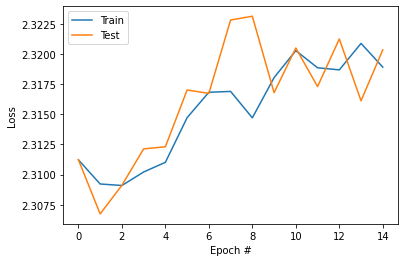

In [10]:
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.plot(trainLosses, label = "Train")
plt.plot(testLosses, label = "Test")
plt.legend();

In [11]:
# Lets calculate accuracies
totalCorrect = 0.
totalCount = 0.
for inputs, targets in trainLoader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max( outputs, axis = 1 )

    totalCorrect += (targets == predictions).sum().item()
    totalCount += targets.shape[0]

print(f"Train Accuracy = {totalCorrect / totalCount}")

totalCorrect = 0.
totalCount = 0.
for inputs, targets in testLoader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max( outputs, axis = 1 )

    totalCorrect += (targets == predictions).sum().item()
    totalCount += targets.shape[0]

print(f"Test Accuracy = {totalCorrect / totalCount}")

Train Accuracy = 0.1
Test Accuracy = 0.1


In [12]:
# Lets look at some samples where 
predictions = np.array([])
for inputs, targets in testLoader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, preds = torch.max( outputs, axis = 1 )

    predictions = np.concatenate( (predictions, preds.cpu().numpy()) )

In [13]:
classes = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''

classes = classes.split("\n")

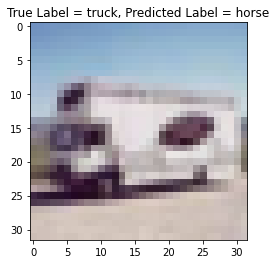

In [14]:
testImages = testDataset.data
testLabels = testDataset.targets

misclassifiedIndices = np.where( predictions != testLabels )[0]
index = np.random.choice(misclassifiedIndices)

plt.imshow( testImages[index] )
plt.title(f"True Label = {classes[ testLabels[index] ]}, Predicted Label = {classes[ int(predictions[index]) ]}");